In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
import random
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define directories and parameters
img_size = 96
classes = [
  'anastasia_idolmaster', 'aqua_konosuba', 'astolfo_fate', 'belfast_azur_lane', 'emilia_rezero',
  'gawr_gura', 'takarada_rikka', 'yui_angel_beats', 'xenovia_high_school_dxd', 'watson_amelia']

def split_indices(num_images, test_ratio=0.2):
  indices = list(range(num_images))
  num_test = int(num_images * test_ratio)
  test_indices = random.sample(indices, num_test)
  train_indices = [i for i in indices if i not in test_indices]
  return test_indices, train_indices

def get_image_labels(class_idx, class_folder, filenames, idxs):
  images = []
  labels = []
  for i in idxs:
    filename = filenames[i]
    img_path = os.path.join(class_folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
      img = cv2.resize(img, (img_size, img_size))
      img = img.astype('float32') / 255.0 # Normalize
      images.append(img)
      labels.append(class_idx)
  return (images, labels)

# Function to load and preprocess images
def load_images_from_folder(folder='./', test_ratio=0.2):
  train_images = []
  train_labels = []
  test_images = []
  test_labels = []
  for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(folder, class_name)
    filenames = os.listdir(class_folder)
    print(f"{class_idx} - {class_name}: {len(filenames)} images")
    test_idx, train_idx = split_indices(len(filenames), test_ratio)
    test_data = get_image_labels(class_idx, class_folder, filenames, test_idx)
    train_data = get_image_labels(class_idx, class_folder, filenames, train_idx)
    test_images.extend(test_data[0])
    test_labels.extend(test_data[1])
    train_images.extend(train_data[0])
    train_labels.extend(train_data[1])
  return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

# Load training and test data
X_train, y_train, X_test, y_test = load_images_from_folder()

print(f"Shape of X_train: {X_train.shape}") # Should be (600, 96, 96, 3)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")  # Should be (149, 96, 96, 3)
print(f"Shape of y_test: {y_test.shape}")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Shape of X_train after split: {X_train.shape}")  # Should be (480, 96, 96, 3)
print(f"Shape of X_val: {X_val.shape}")           # Should be (120, 96, 96, 3)
print(f"Shape of y_train after split: {y_train.shape}")  # Should be (480,)
print(f"Shape of y_val: {y_val.shape}")           # Should be (120,)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(classes))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(classes))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(classes))

# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.05,
  height_shift_range=0.05,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest'
)
datagen.fit(X_train)

0 - anastasia_idolmaster: 75 images
1 - aqua_konosuba: 75 images
2 - astolfo_fate: 75 images
3 - belfast_azur_lane: 75 images
4 - emilia_rezero: 75 images
5 - gawr_gura: 75 images
6 - takarada_rikka: 75 images
7 - yui_angel_beats: 75 images
8 - xenovia_high_school_dxd: 74 images
9 - watson_amelia: 75 images
Shape of X_train: (600, 96, 96, 3)
Shape of y_train: (600,)
Shape of X_test: (149, 96, 96, 3)
Shape of y_test: (149,)
Shape of X_train after split: (480, 96, 96, 3)
Shape of X_val: (120, 96, 96, 3)
Shape of y_train after split: (480,)
Shape of y_val: (120,)


In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load MobileNetV2 base with pretrained weights
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.4),
  Dense(128, activation='relu'),
  Dropout(0.3),
  Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=20)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.1769 - loss: 2.8880 - val_accuracy: 0.3833 - val_loss: 1.8059
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.3715 - loss: 1.7572 - val_accuracy: 0.5333 - val_loss: 1.4163
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.4854 - loss: 1.3954 - val_accuracy: 0.6167 - val_loss: 1.2070
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.5432 - loss: 1.2326 - val_accuracy: 0.6583 - val_loss: 1.0030
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6016 - loss: 1.1578 - val_accuracy: 0.7333 - val_loss: 0.9091
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.6316 - loss: 1.0042 - val_accuracy: 0.6917 - val_loss: 0.9565
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6384 - loss: 0.9411 - val_accuracy: 0.6750 - val_loss: 0.9608
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6994 - loss: 0.7957 - val_accuracy: 0

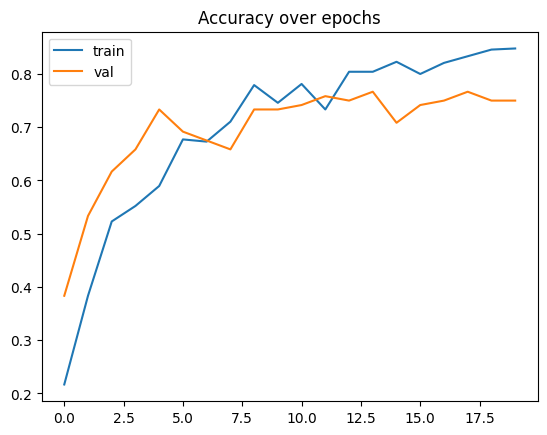

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

model.save('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


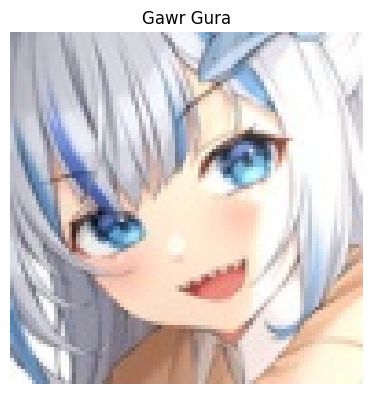

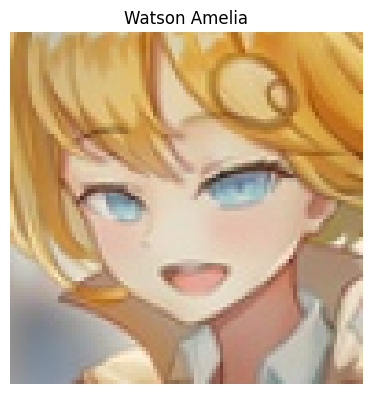

In [22]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

test_ame_dir = './watson_amelia'
test_gura_dir = './gawr_gura'

def load_and_preprocess_image(img_path):
  img = load_img(img_path, target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis=0)
  return img

def find_correctly_classified_image(directory, class_idx):
    for filename in random.choices(os.listdir(directory), k=5):
        img_path = os.path.join(directory, filename)
        img = load_and_preprocess_image(img_path)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        if predicted_class == class_idx:
            return img_path, img
    return None, None

gura_image_path, gura_image = find_correctly_classified_image(test_gura_dir, 5)
ame_image_path, ame_image = find_correctly_classified_image(test_ame_dir, 9)

# Display the images if found
if gura_image is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gura_image.squeeze())
    plt.title('Gawr Gura')
    plt.axis('off')
    plt.show()
else:
    print("No correctly classified Gawr Gura image found.")

if ame_image is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 2)
    plt.imshow(ame_image.squeeze())
    plt.title('Watson Amelia')
    plt.axis('off')
    plt.show()
else:
    print("No correctly classified Watson Amelia image found.")

plt.imsave('gura.png', gura_image.squeeze())
plt.imsave('ame.png', ame_image.squeeze())

In [23]:
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.weights.h5")